# STINTSY Technical Document

### Group FOP:
- Keil Christopher Finez
- Azriel Matthew Ortega
- James Andrew Perez

### Section
- S11

## Description of the Dataset and Task
- An overview or description of the data is provided, including how it was collected, and its implications on the types of conclusions that could be made from the data. A description of the variables, observations, and/or structure of the data is provided. The target task is well introduced and clearly defined.

### Dataset
The Fingers Dataset contains images of a hand holding up fingers from 0 - 5. It includes left-hand and right-hand images, where the left-hand images are generated by flipping the right-hand images. There are 21600 images and have a size of 128 by 128 pixels. The training set will use 18000 images, and the testing set will have 3600. Images are pre-processed by centering them by their center of mass and adding noise patterns to the background. The images were labeled from the last two characters of their file name, L and R for Left and Right; 0,1,2,3,4,5 for the number of fingers raised.

### Task
The goal of this project is to identify the number of fingers the hand is holding, and distinguish between left and right hand.

### Loading the Dataset

Import all of the necessary libraries

In [2]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib as plt
%matplotlib inline

Get the file path for training and test data

In [3]:
trainpath = os.listdir("dest_dataset/train")
testpath = os.listdir("dest_dataset/test")

Put the file paths on the Dataframe

In [4]:
trainpath = ['dest_dataset/train/' + i for i in trainpath]
testpath = ["dest_dataset/test/" + i for i in testpath]

In [5]:
traindata = pd.DataFrame(trainpath, columns=['FilePath'])
testdata = pd.DataFrame(testpath, columns=['FilePath'])

Insert the labels of the images by getting the last two letters of the file name

In [6]:
traindata['Fingers'] = traindata['FilePath'].apply(lambda a: a[-6:-5])
testdata['Fingers'] = testdata['FilePath'].apply(lambda a: a[-6:-5])
traindata['Hand'] = traindata['FilePath'].apply(lambda a: a[-5:-4])
testdata['Hand'] = testdata['FilePath'].apply(lambda a: a[-5:-4])

In [13]:
traindata

,FilePath,Fingers,Hand
0,dest_dataset/train/00048bba-979b-4f84-b833-5bb...,0,L
1,dest_dataset/train/000547a2-d456-4b16-b351-12c...,0,L
2,dest_dataset/train/000cac8e-fcf0-4f8c-bd16-c25...,2,L
3,dest_dataset/train/000d9961-8136-4dee-9820-86e...,0,L
4,dest_dataset/train/0010095b-2e3d-4517-a511-1f6...,5,L
...,...,...,...
17995,dest_dataset/train/ffed5de7-577a-49f8-8912-a51...,0,L
17996,dest_dataset/train/ffef96a9-fe26-4e07-816f-233...,4,L
17997,dest_dataset/train/fff5517f-6329-4588-b0a7-fa4...,0,R
17998,dest_dataset/train/fff79b8e-4d29-4cfa-bba8-687...,2,L


In [8]:
testdata

,FilePath,Fingers,Hand
0,dest_dataset/test/000e7aa6-100b-4c6b-9ff0-e7a8...,5,L
1,dest_dataset/test/001f6021-8581-4ed2-aed4-cda0...,5,L
2,dest_dataset/test/0027029b-4c3c-4785-bc1b-b814...,3,R
3,dest_dataset/test/004599fb-c735-4ff3-a969-342d...,5,L
4,dest_dataset/test/00500e1a-f4bd-4f66-9eb8-c7fc...,5,L
...,...,...,...
3595,dest_dataset/test/ff78cf4f-d03c-4b41-9dbc-03bd...,2,R
3596,dest_dataset/test/ff8be861-dd82-4500-893f-e9b6...,0,L
3597,dest_dataset/test/ff9eeef5-2c62-4bce-9d29-5873...,4,R
3598,dest_dataset/test/ffb7e43c-deac-4b8f-83bf-4443...,3,R


In [9]:
from IPython.display import Image

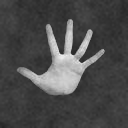

In [10]:
Image(filename=testdata.FilePath[0], width=128,height=128) 

## Exploratory Data Analysis
-  Appropriate summaries and visualizations are presented. Insights into how the EDA can help the model training is mentioned.

## Data pre-processing and cleaning
 - If no preprocessing or cleaning is done, there is a justification on why it was not needed.

### Data pre-processing
In the case of the dataset given by Kaggle, the group did not perform any data pre-processing on the dataset due to it already being pre-processed when downloaded. For the Fingers dataset, the providers had already made the images black and white, made the hands placed in the center through the center of mass, sized at 128x128 pixels, and added noise. No pre-processing was done due to the images being formatted in such a way that it is ready for training.

### Cleaning
No cleaning was done as all data provided were pre-processed and numbered evenly. Upon inspection of the provided dataset, there are 9000 images for the left hand and right hand in training which totals to 18000, and 1800 images for the left and right hand in testing which totals to 3600.

## Model Training
- The appropriate models are used to accomplish the machine learning task. Justification of choosing the models is shown.

## Model selection and hyperparameter tuning
- Appropriate data-driven error analysis is made, and changes to the model selection and hyperparameters are performed to improve model performance. The study exhausts improvements that can be done to the model